In [7]:
!pip install pims av
!python --version

Python 3.7.10


In [11]:
import numpy as np
import cv2
import pims
from tqdm.notebook import trange

import matplotlib.pyplot as plt
from matplotlib.pyplot import plot

import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
#resolution and labels

# TESLA resolution
#W = 1280
#H = 960

# COMMA.AI resolution
#W = 1164
#H = 874

# low resolutions (to avoid low memory problems)
#W = 640
#H = 480
W = 320
H = 160

# this was used for slam
#W = 1920//2
#H = 1080//2

LABEL_DICT = {0: "no crossroad", 1: "crossroad"}  # NOTE: no need to change this for 2 classes (argmax still gets us the same results)

In [9]:
from os import listdir

# Get data from files
def get_data(video_path, log_path):
  # NOTE: it turns out that .txt files work for 2 class classification as well

  # for txt file (binary classification)
  with open(log_path, "r") as log_file:
    labels = log_file.read().split("\n")[:-1]
    log_file.close()

  """
  # for log file (2 class classification)
  with open(log_path, "r") as log_file:
    labels = []
    logs = log_file.read().split("\n")[:-1]
    for row in logs:
      labels.append(row.split(", "))
    log_file.close()
  """
  print("Log file read")

  # make a Video Object instead of loading all frames in memory
  # to access frames just do: frame = frames[n]
  print("Extracting frames ...")
  frames = pims.Video(video_path, format="mp4")
  print("Done extracting frames")

  return frames, np.array(labels).astype(np.float)

video_path = "/content/drive/MyDrive/OpenCRD_dataset/city_1.mp4"  # CHANGE THIS
log_path = video_path[:-3] + "txt"
#log_path = video_path[:-3] + "log"

frames, labels = get_data(video_path, log_path)
print(labels)

# get all files to train model on all of them at once
base_dir = "/content/drive/MyDrive/OpenCRD_dataset/"
video_files = []
log_files = []
for f in listdir(base_dir):
  if f.endswith(".mp4"):
    video_files.append(f)
  elif f.endswith(".txt"):
    log_files.append(f)
video_files, log_files = sorted(video_files), sorted(log_files)
print(video_files)
print(log_files)

Log file read
Extracting frames ...
Done extracting frames
[0. 0. 0. ... 0. 0. 0.]
['city_1.mp4', 'city_2.mp4', 'city_3.mp4', 'city_4.mp4', 'city_highway.mp4']
['city_1.txt', 'city_2.txt', 'city_3.txt', 'city_4.txt', 'city_highway.txt']


crossroad


/usr/local/lib/python3.7/dist-packages/pims/pyav_reader.py:232: MethodDeprecationWarning: VideoStream.seek is deprecated.
  self._stream.seek(timestamp + self._first_pts)


(160, 320, 3)


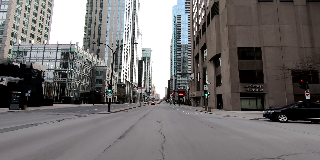

In [ ]:
from google.colab.patches import cv2_imshow

idx = 800
print(LABEL_DICT[labels[idx]])
frame = cv2.resize(cv2.cvtColor(frames[idx], cv2.COLOR_BGR2RGB), (W,H))
print(frame.shape)
cv2_imshow(frame)

In [13]:
# make pims video into actual numpy frames
def conv_frames(frames):
  imgs = []
  print("Getting frames into proper arrays")
  for frame in frames:
    imgs.append(cv2.resize(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB), (W,H)))
  print("Frames converted to numpy arrays")
  return np.array(imgs)

#imgs = conv_frames(frames)
#cv2_imshow(imgs[800])

In [ ]:
# check for undersampling of crossroads (for binary classification .txt log_file)
# prints the percentage of crossroads in the dataset
np.count_nonzero(labels == 1) / len(labels)

0.43634642688121156

In [20]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()

    # image size
    self.W = W
    self.H = H

    # Convolutional Layers
    self.conv1 = nn.Conv2d(3, 16, 5)
    self.pool = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(16, 32, 5)
    self.conv3 = nn.Conv2d(32, 64, 5)

    # Fully connected layers
    self.fc1 = nn.Linear(64 * 16 * 36, 120)     # for 320x160 image 64 channels
    self.bn1 = nn.BatchNorm1d(num_features=120)
    self.fc2 = nn.Linear(120, 84)
    self.bn2 = nn.BatchNorm1d(num_features=84)
    self.fc3 = nn.Linear(84, 1)

  # TODO: add batch normalization to the linear layers and see if that changes anything
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    #print(x.shape)
    x = x.view(-1, self.num_flat_features(x))
    x = F.relu(self.bn1(self.fc1(x)))
    x = F.relu(self.bn2(self.fc2(x)))
    x = F.sigmoid(self.fc3(x))
    return x
  
  def num_flat_features(self, x):
    size = x.size()[1:] # all dimensions except the batch dimension
    num_features = 1
    for s in size:
      num_features *= s
    return num_features


[~] Cleared cuda cache


[~] Training on files: /content/drive/MyDrive/OpenCRD_dataset/city_1.mp4 , /content/drive/MyDrive/OpenCRD_dataset/city_1.txt
Log file read
Extracting frames ...
Done extracting frames
Getting frames into proper arrays
Frames converted to numpy arrays
[+] Epoch 0


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



[+] Epoch 1



[+] Epoch 2



[+] Epoch 3



[+] Epoch 4



[+] Epoch 5



[+] Epoch 6



[+] Epoch 7



[+] Epoch 8



[+] Epoch 9



[+] Epoch 10



[~] Training on files: /content/drive/MyDrive/OpenCRD_dataset/city_2.mp4 , /content/drive/MyDrive/OpenCRD_dataset/city_2.txt
Log file read
Extracting frames ...
Done extracting frames
Getting frames into proper arrays
Frames converted to numpy arrays
[+] Epoch 0



[+] Epoch 1



[+] Epoch 2



[+] Epoch 3



[+] Epoch 4



[+] Epoch 5



[+] Epoch 6



[+] Epoch 7



[+] Epoch 8



[+] Epoch 9



[+] Epoch 10



[~] Training on files: /content/drive/MyDrive/OpenCRD_dataset/city_3.mp4 , /content/drive/MyDrive/OpenCRD_dataset/city_3.txt
Log file read
Extracting frames ...
Done extracting frames
Getting frames into proper arrays
Frames converted to numpy arrays
[+] Epoch 0



[+] Epoch 1



[+] Epoch 2



[+] Epoch 3



[+] Epoch 4



[+] Epoch 5



[+] Epoch 6



[+] Epoch 7



[+] Epoch 8



[+] Epoch 9



[+] Epoch 10



[~] Training on files: /content/drive/MyDrive/OpenCRD_dataset/city_4.mp4 , /content/drive/MyDrive/OpenCRD_dataset/city_4.txt
Log file read
Extracting frames ...
Done extracting frames
Getting frames into proper arrays
Frames converted to numpy arrays
[+] Epoch 0



[+] Epoch 1



[+] Epoch 2



[+] Epoch 3



[+] Epoch 4



[+] Epoch 5



[+] Epoch 6



[+] Epoch 7



[+] Epoch 8



[+] Epoch 9



[+] Epoch 10



[~] Training on files: /content/drive/MyDrive/OpenCRD_dataset/city_highway.mp4 , /content/drive/MyDrive/OpenCRD_dataset/city_highway.txt
Log file read
Extracting frames ...
Done extracting frames
Getting frames into proper arrays
Frames converted to numpy arrays
[+] Epoch 0



[+] Epoch 1



[+] Epoch 2



[+] Epoch 3



[+] Epoch 4



[+] Epoch 5



[+] Epoch 6



[+] Epoch 7



[+] Epoch 8



[+] Epoch 9



[+] Epoch 10




[+] Trained model on all data files


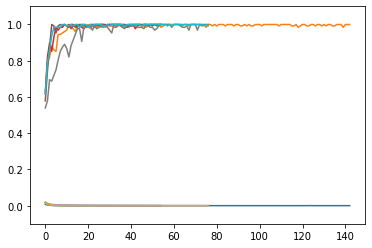

In [21]:
# train the network
def train(frames, labels, model):
  loss_function = nn.BCELoss()  # for binary classification
  optim = torch.optim.Adam(model.parameters(), lr=0.001) 

  losses, accuracies = [], []
  epochs = 11
  BS = 128
  
  # for rounding up to a threshold instead of 0.5 (works with torch.where)
  x = torch.ones(128, 1).to(device)
  y = torch.zeros(128, 1).to(device)

  for epoch in range(epochs):
    print("[+] Epoch", epoch)
    t = trange(0, int(0.8 * len(frames)) - BS, BS)  # trange progress bar on 80% training split
    visited_idx = np.array([])

    # train split = 80%
    for i in t:
      # get data into network
      rng = np.random.default_rng()
      samp = rng.choice(len(frames), size=BS, replace=False)
      visited_idx = np.concatenate((visited_idx, samp)) # add the new random values to visited indices

      # TODO: we must not sample the same frames in the same epoch (use visited_idx)
      X_train = []
      Y_train = []
      for j in samp:
        frame = frames[j]
        frame = np.moveaxis(frame, -1, 0) # [batch_size, channels, height, width]
        X_train.append(frame)
        Y_train.append([labels[j]])
      X = torch.tensor(np.array(X_train)).float().to(device)
      Y = torch.tensor(np.array(Y_train)).float().to(device)

      # forward feed and backpropagation
      optim.zero_grad()
      out = model(X)
      #cat = torch.round(out)
      cat = torch.where(out >= 0.7, x, y) # round up to a threshold instead of 0.5
      accuracy = (cat == Y).float().mean()
      loss = loss_function(out, Y)
      loss = loss.mean()
      loss.backward()
      optim.step()

      # print stats
      loss = loss.item()
      accuracy = accuracy.item()
      losses.append(loss/100) # /100 so that we can see it in the graph
      accuracies.append(accuracy)
      t.set_description("loss %.2f accuracy %.2f out %.2f" % (loss, accuracy, out.mean().item()))

  # plot losses and accuracies
  plt.ylim(-0.1, 1.1)
  plot(losses)
  plot(accuracies)

  return model

if device.type == "cuda":
  torch.cuda.empty_cache()  # to avoid running out of cuda memory
  print("[~] Cleared cuda cache")

# train for all files
model = ConvNet().to(device).train() # Uncomment this if you want to train from the start, else just run the loader block first

for i in trange(len(video_files)):
  print("[~] Training on files: %s , %s" % (base_dir+video_files[i], base_dir+log_files[i]))
  frames, labels = get_data(base_dir+video_files[i], base_dir+log_files[i])
  frames = conv_frames(frames)
  model = train(frames, labels, model)
print("[+] Trained model on all data files")

In [ ]:
# TODO: FIX THIS SEGMENT (crashes and doesn't work properly)
# evaluate model
# TODO: create test data (split the dataset beforehand)
def evaluate(model, X_test, Y_test):
  # prepare data
  X_test = np.moveaxis(X_test, -1, 0)
  Y_test = np.array([[Y_test]])

  X = torch.tensor(X_train).float().to(device)
  X  = X.unsqueeze(0)
  Y = torch.tensor(Y_train).float().to(device)

  # TODO: we are out of RAM
  #Y_test_preds = torch.round(model(torch.tensor(X_test).float().unsqueeze(0).to(device), dim=1).numpy())
  Y_test_preds = []
  for i in trange(int(0.2*len(frames))):
    Y_test_pred = torch.round(model(torch.tensor(X_test[int(0.8*len(frames))+i]).unsqueeze(0).to(device), dim=1).numpy())
    Y_test_preds.append(Y_test_pred)
  Y_test_preds = np.array(Y_test_preds)
  print((Y_test == Y_test_preds).mean())

evaluate(model, frames, labels[int(0.8*len(frames)):])

In [42]:
# save model for later retraining
model_path = "/content/drive/MyDrive/OpenCRD_dataset/models/cr_detector.pth"
torch.save(model.state_dict(), model_path)
print("Model saved to path", model_path)

Model saved to path /content/drive/MyDrive/OpenCRD_dataset/models/cr_detector.pth


In [24]:
# load the model
model_path = "/content/drive/MyDrive/OpenCRD_dataset/models/cr_detector.pth"
model = ConvNet()
model.load_state_dict(torch.load(model_path))
model.train()  # for training on new dataset
#model.eval()  # for evaluation
model.to(device)

ConvNet(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=36864, out_features=120, bias=True)
  (bn1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)

/usr/local/lib/python3.7/dist-packages/pims/pyav_reader.py:232: MethodDeprecationWarning: VideoStream.seek is deprecated.
  self._stream.seek(timestamp + self._first_pts)


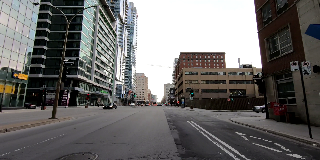

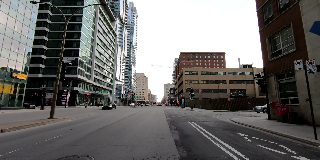

Frame: 2050
[+] 1 -> crossroad
Frame: 2051
[+] 1 -> crossroad
tensor([[0.8857],
        [0.8857]], device='cuda:0', grad_fn=<SigmoidBackward>)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1709: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [41]:
from google.colab.patches import cv2_imshow

eval_path = "/content/drive/MyDrive/OpenCRD_dataset/city_1.mp4"
log_path = eval_path[:-4] + ".txt"

with open(log_path, "r") as log_file:
  eval_labels = log_file.read().split("\n")[:-1]
  log_file.close()

frames = pims.Video(eval_path, format="mp4")
idx = 2050

frame1 = cv2.resize(cv2.cvtColor(frames[idx], cv2.COLOR_BGR2RGB), (W,H))
frame2 = cv2.resize(cv2.cvtColor(frames[idx+1], cv2.COLOR_BGR2RGB), (W,H))
cv2_imshow(frame1)
cv2_imshow(frame2)
print("Frame:", idx)
print("[+]", eval_labels[idx], "->", LABEL_DICT[int(eval_labels[idx])])
print("Frame:", idx+1)
print("[+]", eval_labels[idx+1], "->", LABEL_DICT[int(eval_labels[idx+1])])
    
# forward to model
# NOTE: since we are using batch normalization, we need more than 1 images
X_test1 = np.moveaxis(frame1, -1, 0)
X_test2 = np.moveaxis(frame1, -1, 0)
X_test = []
X_test.append(X_test1)
X_test.append(X_test2)
X_test = np.array(X_test)
X = torch.tensor(X_test).float().to(device)

model.eval()
Y_pred = model(X)
print(Y_pred)

In [ ]:
# evaluate whole video
cap = cv2.VideoCapture(eval_path)
Y_preds = []

idx = 0
while True:
  ret, frame = cap.read()
  if ret:
    # display frame
    frame = cv2.resize(frame, (W,H))
    cv2_imshow(frame)
    print("Frame:", idx)
    print("[+]", eval_labels[idx], "->", LABEL_DICT[int(eval_labels[idx])])
    

    # forward to model
    X_test = np.moveaxis(frame, -1, 0)
    X = torch.tensor(X_test).float().to(device)
    X = X.unsqueeze(0)
    print(X.shape)

    Y_pred = torch.round(model(X))
    Y_preds.append(Y_pred)
    print("[~]", Y_pred.item())

    if cv2.waitKey(0) & 0xff == ord('q'):
      break
    idx += 1
  else:
    break

#Y_test = np.array([[eval_labels])
#Y_preds = np.array(Y_preds)
#print((Y_test == Y_preds).mean())